In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import re

import multiprocessing

# logging config
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# read data file: contains all text data concatenated into a single file
# with open('../data/AllCombined.txt', 'r', encoding='utf-8') as f:
#     contents = f.read()


# read data
df = pd.read_csv('../data/twitter/train.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
contents = list(df['text'])[:500000]

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yjiah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yjiah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yjiah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# preprocessing:
# split text into sentences using fullstop
# tokenize the split sentences into words
# remove stopwords
# remove punctuation
# lemmatization

# split text into sentences by fullstop and lowercase everything up to 20000 sentences
sentences_lst = [tweet.lower() for tweet in contents]

# remove punctuation
sentences_lst_removed_punc = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences_lst]

# tokenize the split sentences into words
tokenized_sentences = [sentence.split() for sentence in sentences_lst_removed_punc]

# stopword removal
# stop_words = set(stopwords.words('english'))
# filtered_tokenized_sentences = [[word for word in sentence if word not in stop_words] for sentence in tokenized_sentences]

# lemmatization
# lemmatizer = WordNetLemmatizer()
# filtered_tokenized_sentences = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in tokenized_sentences]

In [5]:
len(tokenized_sentences)

500000

In [6]:
# train the model

model = Word2Vec(
    tokenized_sentences,
    vector_size=300,
    window=5,
    min_count=1,
    sg=1,
    epochs=10,
    negative=10,
    workers=12
)

2025-08-16 20:00:43,474 : INFO : collecting all words and their counts
2025-08-16 20:00:43,475 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-08-16 20:00:43,509 : INFO : PROGRESS: at sentence #10000, processed 134601 words, keeping 17783 word types
2025-08-16 20:00:43,527 : INFO : PROGRESS: at sentence #20000, processed 267415 words, keeping 28936 word types
2025-08-16 20:00:43,557 : INFO : PROGRESS: at sentence #30000, processed 399736 words, keeping 38313 word types
2025-08-16 20:00:43,585 : INFO : PROGRESS: at sentence #40000, processed 532834 words, keeping 46941 word types
2025-08-16 20:00:43,614 : INFO : PROGRESS: at sentence #50000, processed 666485 words, keeping 55719 word types
2025-08-16 20:00:43,656 : INFO : PROGRESS: at sentence #60000, processed 800600 words, keeping 63664 word types
2025-08-16 20:00:43,692 : INFO : PROGRESS: at sentence #70000, processed 932799 words, keeping 71379 word types
2025-08-16 20:00:43,724 : INFO : PROGRESS: at 

In [7]:
# save the trained model
model.save("./models/word2vec_skipgram_300_500k.model")

2025-08-16 20:07:27,846 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec_skipgram_300_500k.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-16T20:07:27.846674', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-16 20:07:27,847 : INFO : storing np array 'vectors' to ./models/word2vec_skipgram_300_500k.model.wv.vectors.npy
2025-08-16 20:07:28,345 : INFO : storing np array 'syn1neg' to ./models/word2vec_skipgram_300_500k.model.syn1neg.npy
2025-08-16 20:07:28,930 : INFO : not storing attribute cum_table
2025-08-16 20:07:29,075 : INFO : saved ./models/word2vec_skipgram_300_500k.model


## Analysis

### Nearest Neighbours for selected words

In [8]:
selected_words = [
    'cow',
    'fight',
    'chemistry',
    'month',
    'energy'
]

for word in selected_words:
    print(f'Word is: {word}')
    print(model.wv.most_similar(word))
    print("*" * 30)

Word is: cow
[('chipmunk', 0.6460306644439697), ('screamer', 0.6284345388412476), ('lint', 0.626642644405365), ('safeway', 0.6233818531036377), ('serda23', 0.6170419454574585), ('cocaine', 0.6150082945823669), ('unicorn', 0.6147449016571045), ('vegetarianism', 0.6144837141036987), ('snickers', 0.6143288612365723), ('fuckign', 0.6124183535575867)]
******************************
Word is: fight
[('barroni', 0.5539336204528809), ('thor', 0.5521543025970459), ('showdown', 0.5462876558303833), ('hooter', 0.5446524620056152), ('quotcry', 0.5443355441093445), ('gameand', 0.5437572002410889), ('leesburg', 0.54250568151474), ('argument', 0.5423554182052612), ('pacquiaos', 0.5422510504722595), ('gamehe', 0.5419832468032837)]
******************************
Word is: chemistry
[('biology', 0.7293006181716919), ('algebra', 0.718833327293396), ('mathematics', 0.7090718150138855), ('chem', 0.7076356410980225), ('geog', 0.7047707438468933), ('computing', 0.7045590877532959), ('physics', 0.70436549186706

Similar words are mostly reasonable

### Visualization of PCA embedding space

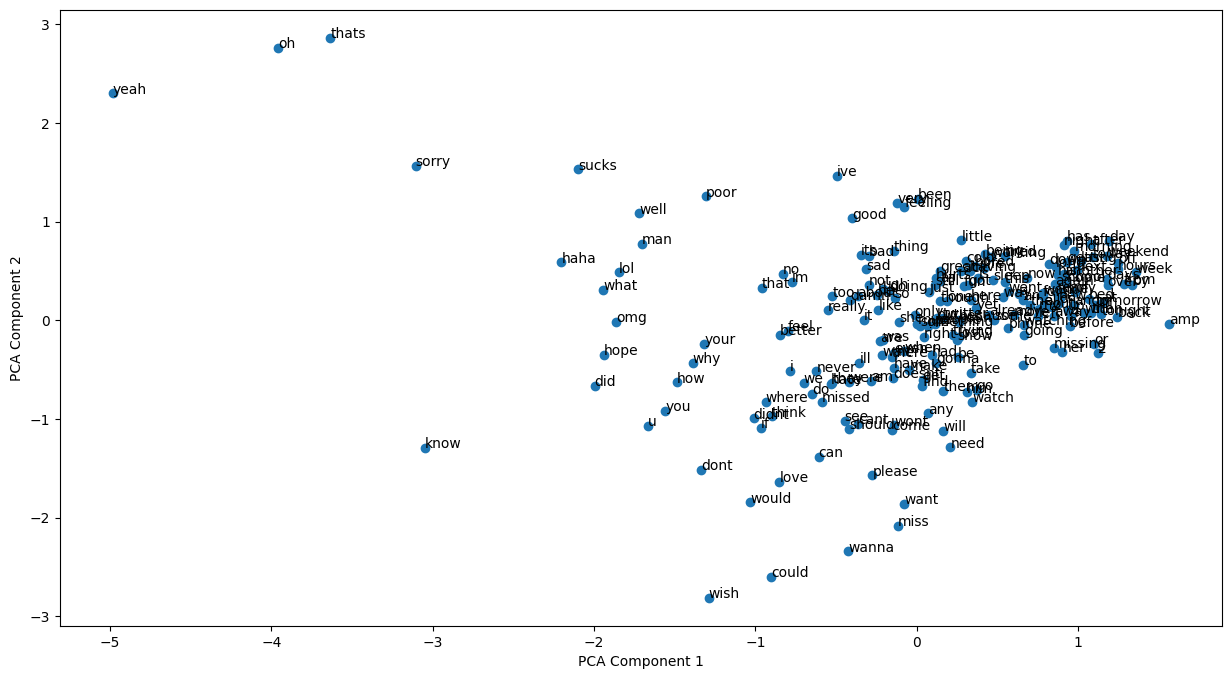

In [11]:
words = list(model.wv.index_to_key[0:200])
embeddings = model.wv[words]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

We can see that some words like 'haha', 'lol' are clustered together